# Shortbred annotations to antimicrobial resistance

Let's look at the shortbred amr annotations to amr genes. We'll focus on the following questions:

1. What types and profiles of AMR genes do we see in the patients and donors at baseline?
2. What fluctuations in AMR genes do we see upon administration of antibiotics?
3. What changes in AMR genes do we see in the placebo patients as environmental bacteria engraft?
4. What AMR genes do we see transfer from the donors to the recipients from FMT?
5. What is the eventual AMR profile of placcebo and FMT patients?
6. How much does the AMR MGX information mirror that of the overall taxonomic patterns?

In [1]:
import pathlib, itertools
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np
import scipy.spatial.distance as dist, itertools
import skbio.diversity as div, scipy.stats as stats, skbio.stats.ordination as ordination
from matplotlib.lines import Line2D

sns.set_style('white')
%matplotlib inline

In [2]:
#get patient colors
dd_pat_col = {'0044': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
              '0073': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
              '001': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
              '004': (1.0, 0.4980392156862745, 0.054901960784313725),
              '005': (1.0, 0.7333333333333333, 0.47058823529411764),
              '006': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
              '007': (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
              '008': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
              '009': (1.0, 0.596078431372549, 0.5882352941176471),
              '010': (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
              '011': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
              '012': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
              '013': (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
              '014': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274)}
dd_pat_col_name = {'patient_' + str(k): v for k, v in dd_pat_col.items()}

#get patient colors on treatment
dd_pat_treat = {'0044': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
              '0073': (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
              '001': sns.color_palette()[0], '004': sns.color_palette()[1],
              '005': sns.color_palette()[1], '006': sns.color_palette()[1],
              '007': sns.color_palette()[0], '008': sns.color_palette()[0],
              '009': sns.color_palette()[1], '010': sns.color_palette()[0],
              '011': sns.color_palette()[0], '012': sns.color_palette()[1],
              '013': sns.color_palette()[1], '014': sns.color_palette()[0]}
dd_pat_treat_name = {'patient_' + str(k): v for k, v in dd_pat_treat.items()}

#get patient dashes on responder
dd_pat_dash = {'0044': (), '0073': (),
               '001': (), '004': (), '005': (),
               '006': (), '007': (3, 2), '008': (3, 2),
               '009': (), '010': (), '011': (),
               '012': (), '013': (), '014': (3, 2)}
dd_pat_dash_name = {'patient_' + str(k): v for k, v in dd_pat_dash.items()}

In [3]:
#read in metadata
md = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_stool_dna_NV022018.tsv',
                 sep='\t', dtype={'patient': 'object',
                                  'fmt': 'object'})
md.loc[:, 'patient_plt'] = 'patient_' + md['patient']

#read in patient metadata
md_pat = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metadata/metadata_patients_2019-04-10.tsv',
                     sep='\t', dtype={'patient': 'object',
                                      'fmt': 'object',
                                      'fmt_induction': 'object'})

In [4]:
#read in annotations
db = '/Users/ndchu/Documents/uc_fmt/metagenomics/function/amr/cheng_amr_10.1.2018_update'
ncbi_amr = pd.read_csv(db + '/ncbi_amr_db_mapping_nucleotide.csv')
card_amr = pd.read_csv(db + '/card_amr_class_annotation.csv')

In [5]:
#get samples that have mgx sequencing
samples = md.loc[(md['reads_mgx'] > 0) & (md['patient'].notnull())]['sample_id'].unique()

## Reading in output data

In [ ]:
#read in the data from each sample
in_dir = pathlib.Path('/Users/ndchu/Documents/uc_fmt/metagenomics/amr/sb_AG102018/')
files = list(in_dir.iterdir())
samples = [str(x).split('_sbresults')[0].split('/')[-1] for x in files]

#read in datafiles
dfs = [pd.read_csv(file, sep='\t') for file in files]

#add sample information to each df
for df, sample in zip(dfs, samples):
    df.loc[:, 'sample'] = sample

#combine these dataframes
amr_sb = pd.concat(dfs)

#remove amr genes that are absent
amr_sb = amr_sb.loc[(amr_sb['Count'] != 0) & (amr_sb['Hits'] != 0)]

#reset index
amr_sb = amr_sb.reset_index(drop=True)

In [31]:
#write this to a file
amr_sb.to_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/amr/sb_AG102018/amr_sb_all.tsv.gz',
              sep='\t', compression='gzip', index=False)

In [6]:
#read in the file
amr_sb = pd.read_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/function/amr/sb_AG102018/amr_sb_all.tsv.gz',
                     sep='\t', compression='gzip')

In [7]:
#add metadata
amr_sb = amr_sb.merge(md, left_on='sample', right_on='sample_id')

#add antibiotic information
amr_class = pd.concat([ncbi_amr[['genbank_prot_accession', 
                                 'antibiotic_class']].rename(columns={'genbank_prot_accession': 'prot_accession'}),
                       card_amr[['Protein Accession', 
                                 'antibiotic_class']].rename(columns={'Protein Accession': 'prot_accession'}),
                       ncbi_amr[['refseq_prot_accession', 
                                 'antibiotic_class']].rename(columns={'refseq_prot_accession': 'prot_accession'})])

#get rid of strain
amr_class.loc[:, 'prot_accession_nostr'] = amr_class['prot_accession'].str.split('.').str[0]
tmp_dict = amr_class.set_index('prot_accession_nostr').to_dict()['antibiotic_class']

#add abx information
amr_sb.loc[:, 'prot_accession'] = amr_sb['Family'].str.split('|').str[1]
tmp = []
for x in amr_sb['prot_accession']:
    test = x.rsplit('_', 1)[0]
    if len(test) > 2:
        tmp.append(test)
    else:
        tmp.append(x)
amr_sb.loc[:, 'antibiotic_class'] = [tmp_dict[x] for x in tmp]

In [9]:
#create a feature table
amr_sb_ftab = amr_sb.pivot(index='sample', columns='Family', values='Count').fillna(0)
#look at the presense of data across the table
amr_sb_ftab.astype(bool).sum().sum() / amr_sb_ftab.size

0.1131757766574338

In [10]:
#add antibiotics class data
amr_sb.loc[:, 'accession'] = amr_sb['Family'].str.split('|').str[1]

ncbi_amr.loc[:, 'accession'] = ncbi_amr['refseq_prot_accession'].str.replace('.', '_', regex=False)
card_amr.loc[:, 'accession'] = card_amr['Protein Accession'].str.replace('.', '_', regex=False)
acc_cls_map = pd.concat([ncbi_amr[['accession', 'antibiotic_class']], 
                         card_amr[['accession', 'antibiotic_class']]])

amr_sb = amr_sb.merge(acc_cls_map)

## Overall patterns and distributions

1. How many amr genes are shared across samples?
2. How many amr genes occur in each sample?

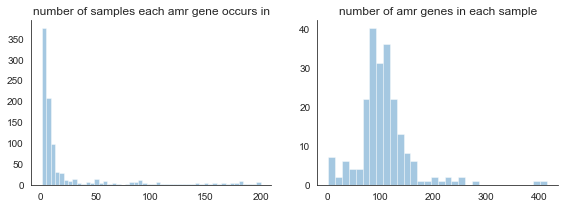

In [54]:
#plot how many samples each gene family occurs in
n_sam = amr_sb.groupby('Family').size()
n_amr = amr_sb.groupby('sample_id').size()

fig = plt.figure(figsize = (8,3))

ax1 = fig.add_subplot(1,2,1)
sns.distplot(n_sam, kde=False)
ax1.set_title('number of samples each amr gene occurs in')

ax2 = fig.add_subplot(1,2,2)
sns.distplot(n_amr, kde=False)
ax2.set_title('number of amr genes in each sample')

sns.despine()
plt.tight_layout()

So a number of amr gene families occur in only 1 or 2 samples. But, amr gene families that occur in only 1 sample are only 0.6% of the total, which is relatively small. In a feature table format, the table is about 11% full, meaning that traditional PCA probably won't be useful.

## Characterizing baseline AMR profiles

What do these patients look like initially? Let's do a PCoA to look at overall patterns in the sample.

In [76]:
from scipy.stats import entropy
from numpy.linalg import norm

def JSD(P, Q):
    """
    Calculates jensen-shannon divergence.
    """
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

In [80]:
# get a distance matrix of JSD distances
jsd = dist.pdist(amr_sb_ftab.values, metric=JSD)
#turn into df
jsd = pd.DataFrame(dist.squareform(jsd),
                   columns=amr_sb_ftab.index,
                   index=amr_sb_ftab.index)

In [84]:
#calculate pcoa
pcoa_jsd = ordination.pcoa(jsd)
#get pcoa results
pcoa_jsd_coords = pcoa_jsd.samples
#replace indexes
pcoa_jsd_coords.index = amr_sb_ftab.index

#add metadata to the dataframes
pcoa_jsd_coords = pcoa_jsd_coords.merge(md, left_index=True, 
                                        right_on='sample_id').sort_values('patient')

#make a patient category that doesn't look like numbers for seaborn
pcoa_jsd_coords.loc[:, 'patient_plt'] = 'patient_' + pcoa_jsd_coords['patient']

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.5151302326216646 and the largest is 4.69757362972298.
  RuntimeWarning


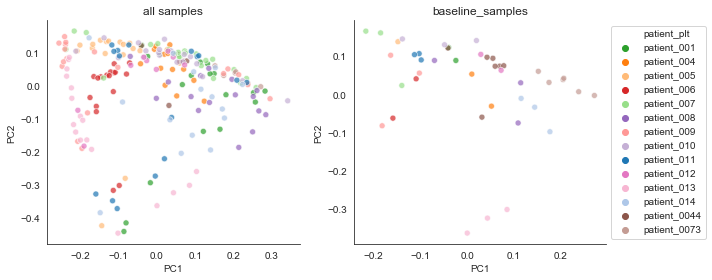

In [91]:
#plot these new pcoa points
hue_order = ['patient_001', 'patient_004', 'patient_005',
             'patient_006', 'patient_007', 'patient_008',
             'patient_009', 'patient_010', 'patient_011',
             'patient_012', 'patient_013', 'patient_014',
             'patient_0044', 'patient_0073']

fig = plt.figure(figsize = (10,4))

#plot all of the samples
ax1 = fig.add_subplot(1,2,1)
sns.scatterplot(x='PC1', y='PC2', hue='patient_plt', data=pcoa_jsd_coords,
                palette=dd_pat_col_name, alpha=0.7, hue_order=hue_order)
plt.title('all samples')
ax1.legend_.remove()

#plot only baseline samples
ax3 = fig.add_subplot(1,2,2)
bl_pcoa = pcoa_jsd_coords.loc[(pcoa_jsd_coords['days_past_fmt'] < -5) |
                              (pcoa_jsd_coords['patient_donor'] == 'donor')]
sns.scatterplot(x='PC1', y='PC2', hue='patient_plt', data=bl_pcoa,
                palette=dd_pat_col_name, alpha=0.7, hue_order=hue_order)
plt.title('baseline_samples')
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.despine()
plt.tight_layout()

#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/pcoa_16S_SP182018.png',
#            dpi=300)

### Mean distance from the donors

In [92]:
#list donor samples
sam_0044 = md.loc[md['patient'] == '0044']['sample_id'].tolist()
sam_0073 = md.loc[md['patient'] == '0073']['sample_id'].tolist()

#get mean distance
mean_jsd_donor = jsd[sam_0044 + sam_0073].mean(axis=1)
mean_jsd_donor = mean_jsd_donor.to_frame(name='jsd').merge(md, left_index=True,
                                                           right_on='sample_id')

#get mean distances between donor samples
mean_jsd_btw = [jsd.loc[x, y] for x, y in itertools.product(sam_0044, sam_0073)]
mean_jsd_btw = np.mean(mean_jsd_btw)

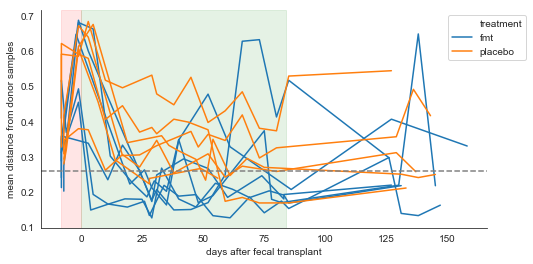

In [93]:
#Do we see a convergence in AMR profiles with FMT?
fig = plt.figure(figsize = (8,4))
ax = sns.lineplot(x='days_past_fmt', y='jsd', 
                  hue='treatment', units='patient',
                  data=mean_jsd_donor,
                  estimator=None)
#label axes
ax.set_ylabel('mean distance from donor samples')
ax.set_xlabel('days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean distance between donor samples
ax.axhline(mean_jsd_btw, color='grey', linestyle='dashed')

ax.legend(loc='upper left', bbox_to_anchor=(.9, 1))

sns.despine()

#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/donor_dist_16S_SP182018.png',
#            dpi=300)

### Diveristy of AMR genes

In [9]:
def shannon(values):
    """
    Calculates shannon diversity of the iterable values
    which can be counts or frequencies
    """
    total = sum(values)
    freq = [x / total for x in values]
    return -sum([x * np.log2(x) for x in freq])

In [10]:
#get number of observed AMR families
n_amr_obs_df = amr_sb.groupby('sample').size().rename('n_amr_obs')
#get cumulative sum of the amr read frequencies
abun_amr_df = amr_sb.groupby('sample')['Count'].sum().rename('abun_amr')
#get shannon
shannon_df = amr_sb.groupby('sample')['Count'].apply(shannon).rename('shannon')

In [11]:
#add metadata
n_amr_obs_df = n_amr_obs_df.to_frame().merge(md, left_index=True, right_on='sample_id')
abun_amr_df = abun_amr_df.to_frame().merge(md, left_index=True, right_on='sample_id')
shannon_df = shannon_df.to_frame().merge(md, left_index=True, right_on='sample_id')

In [12]:
#get averages of these values from donor samples
obs_amr_0044 = n_amr_obs_df.loc[n_amr_obs_df['patient'] == '0044']['n_amr_obs'].mean()
obs_amr_0073 = n_amr_obs_df.loc[n_amr_obs_df['patient'] == '0073']['n_amr_obs'].mean()

abun_amr_0044 = abun_amr_df.loc[abun_amr_df['patient'] == '0044']['abun_amr'].mean()
abun_amr_0073 = abun_amr_df.loc[abun_amr_df['patient'] == '0073']['abun_amr'].mean()

shannon_amr_0044 = shannon_df.loc[shannon_df['patient'] == '0044']['shannon'].mean()
shannon_amr_0073 = shannon_df.loc[shannon_df['patient'] == '0073']['shannon'].mean()

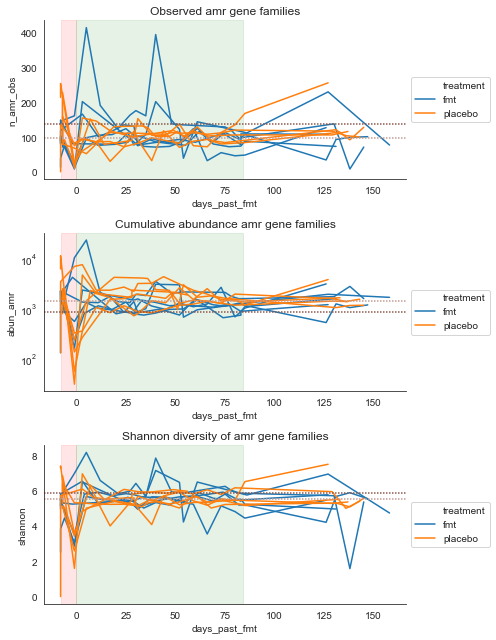

In [92]:
#plot shannon diversity
fig = plt.figure(figsize = (7,9))

ax1 = fig.add_subplot(3,1,1)
sns.lineplot(x='days_past_fmt', y='n_amr_obs',
             hue='treatment', units='patient',
             data=n_amr_obs_df, estimator=None)
ax1.set_title('Observed amr gene families')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#label regions of the graph
ax1.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax1.axvspan(0, 84, alpha=0.1, color='green') #capsules
#add mean values from donors
ax1.axhline(obs_amr_0044, dashes=(1,1), color=dd_pat_col['0044'])
ax1.axhline(obs_amr_0073, dashes=(1,1), color=dd_pat_col['0073'])

ax2 = fig.add_subplot(3,1,2)
sns.lineplot(x='days_past_fmt', y='abun_amr',
             hue='treatment', units='patient',
             data=abun_amr_df, estimator=None)
ax2.set_title('Cumulative abundance amr gene families')
ax2.set_yscale('log')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#label regions of the graph
ax2.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax2.axvspan(0, 84, alpha=0.1, color='green') #capsules
#add mean values from donors
ax2.axhline(abun_amr_0044, dashes=(1,1), color=dd_pat_col['0044'])
ax2.axhline(abun_amr_0073, dashes=(1,1), color=dd_pat_col['0073'])
    
ax3 = fig.add_subplot(3,1,3)
sns.lineplot(x='days_past_fmt', y='shannon',
             hue='treatment', units='patient',
             data=shannon_df, estimator=None)
ax3.set_title('Shannon diversity of amr gene families')
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#label regions of the graph
ax3.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax3.axvspan(0, 84, alpha=0.1, color='green') #capsules
#add mean values from donors
ax3.axhline(shannon_amr_0044, dashes=(1,1), color=dd_pat_col['0044'])
ax3.axhline(shannon_amr_0073, dashes=(1,1), color=dd_pat_col['0073'])

sns.despine()
plt.tight_layout()

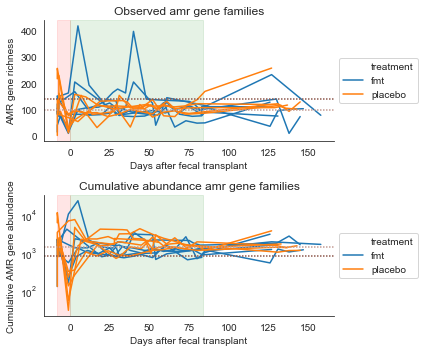

In [14]:
# Plot richness and cumulative abundance
fig = plt.figure(figsize = (6,5))

ax1 = fig.add_subplot(2,1,1)
sns.lineplot(x='days_past_fmt', y='n_amr_obs',
             hue='treatment', units='patient',
             data=n_amr_obs_df, estimator=None)
ax1.set_title('Observed amr gene families')
ax1.set_xlabel('Days after fecal transplant')
ax1.set_ylabel('AMR gene richness')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#label regions of the graph
ax1.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax1.axvspan(0, 84, alpha=0.1, color='green') #capsules
#add mean values from donors
ax1.axhline(obs_amr_0044, dashes=(1,1), color=dd_pat_col['0044'])
ax1.axhline(obs_amr_0073, dashes=(1,1), color=dd_pat_col['0073'])

ax2 = fig.add_subplot(2,1,2)
sns.lineplot(x='days_past_fmt', y='abun_amr',
             hue='treatment', units='patient',
             data=abun_amr_df, estimator=None)
ax2.set_title('Cumulative abundance amr gene families')
ax2.set_xlabel('Days after fecal transplant')
ax2.set_ylabel('Cumulative AMR gene abundance')
ax2.set_yscale('log')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#label regions of the graph
ax2.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax2.axvspan(0, 84, alpha=0.1, color='green') #capsules
#add mean values from donors
ax2.axhline(abun_amr_0044, dashes=(1,1), color=dd_pat_col['0044'])
ax2.axhline(abun_amr_0073, dashes=(1,1), color=dd_pat_col['0073'])

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amr_gene_abun_2019-05-05.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amr_gene_abun_2019-05-05.pdf',
            dpi=300)

In [9]:
#plot quinolone resistance frequency and number of families over time
amr_quin = amr_sb.loc[amr_sb['antibiotic_class'] == 'quinolone']

#get number of observed AMR families
n_quin_obs_df = amr_quin.groupby('sample').size().rename('n_quin_obs')
#get cumulative sum of the amr read frequencies
abun_quin_df = amr_quin.groupby('sample')['Count'].sum().rename('abun_quin')

#add metadata
n_quin_obs_df = n_quin_obs_df.to_frame().merge(md, left_index=True, right_on='sample_id')
abun_quin_df = abun_quin_df.to_frame().merge(md, left_index=True, right_on='sample_id')

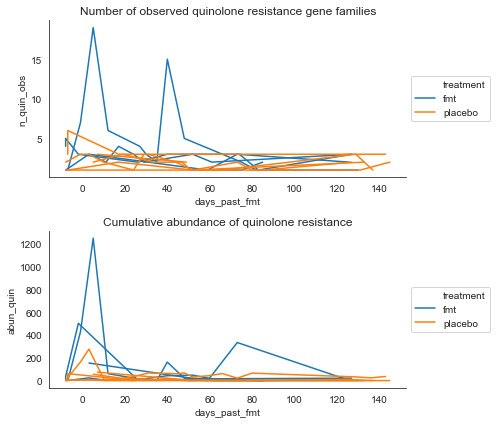

In [85]:
#plot quinolone diversity
fig = plt.figure(figsize = (7,6))

ax1 = fig.add_subplot(2,1,1)
sns.lineplot(x='days_past_fmt', y='n_quin_obs',
             hue='treatment', units='patient',
             data=n_quin_obs_df, estimator=None)
ax1.set_title('Number of observed quinolone resistance gene families')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax2 = fig.add_subplot(2,1,2)
sns.lineplot(x='days_past_fmt', y='abun_quin',
             hue='treatment', units='patient',
             data=abun_quin_df, estimator=None)
ax2.set_title('Cumulative abundance of quinolone resistance')
#ax2.set_yscale('log')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

sns.despine()
plt.tight_layout()

So we can see selection for quinolone resistance, but it looks pretty temporary here. Let's plot each of thes antibiotic classes seperately.

In [16]:
#get abundance of each antibiotic class in each sample
amr_cls = amr_sb[['sample', 'Count', 'antibiotic_class']].groupby(['sample', 'antibiotic_class']).sum()
amr_cls = amr_cls.reset_index()
amr_cls = amr_cls.merge(md, left_on='sample', right_on='sample_id')

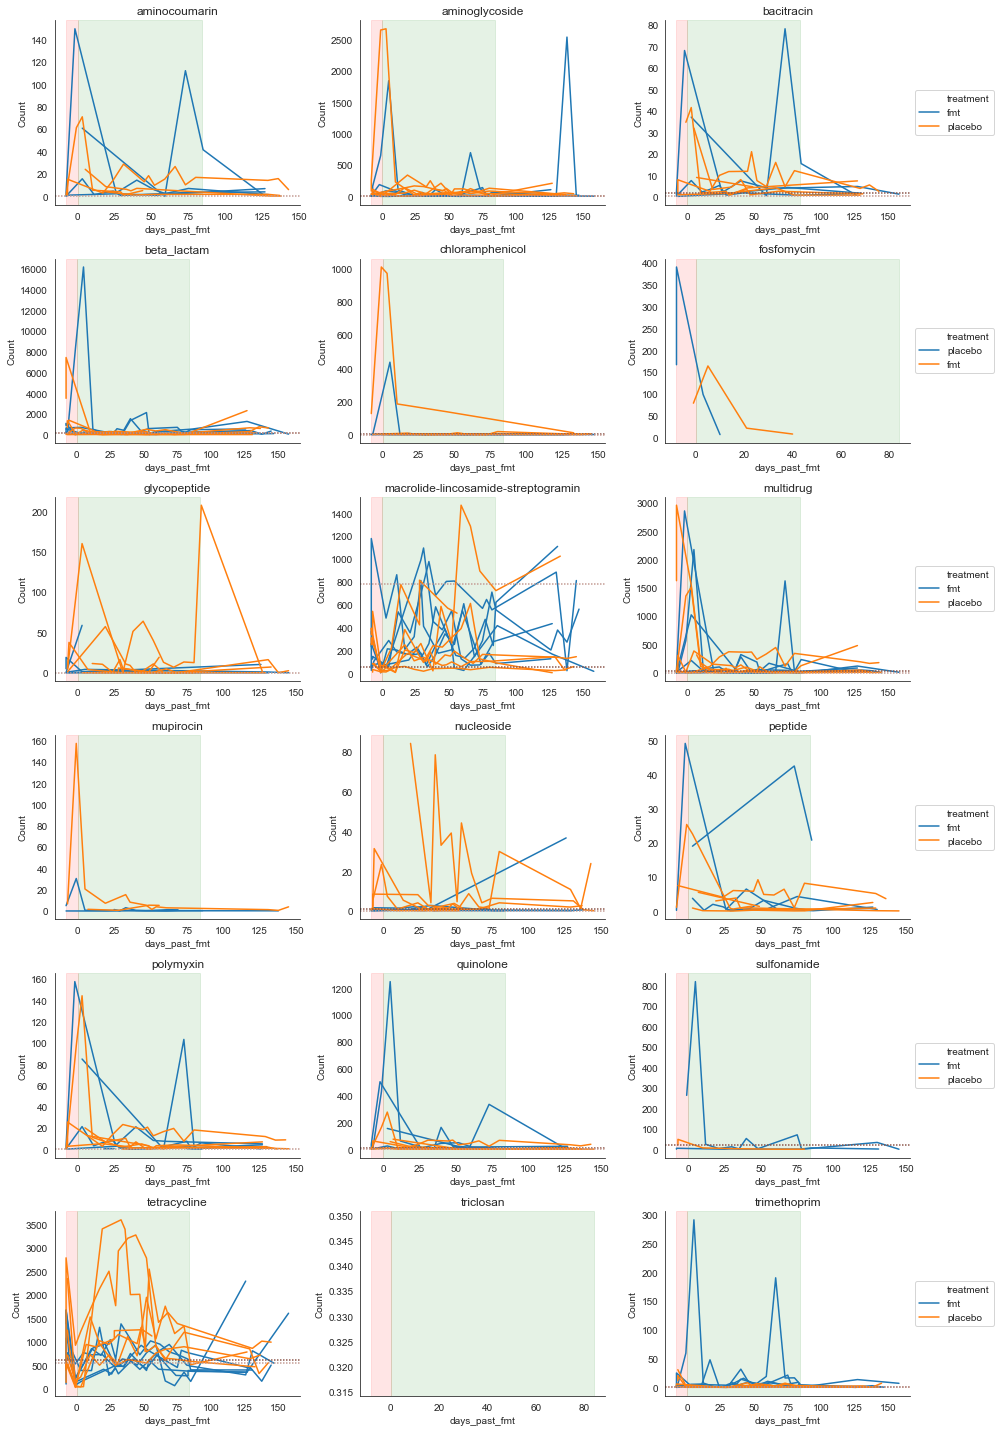

In [86]:
#plot each antibiotic class seperately
fig = plt.figure(figsize = (14,20))

counter = 1
for abx_cls, sub_df in amr_cls.groupby('antibiotic_class'):
    ax = fig.add_subplot(6,3,counter)
    sns.lineplot(x='days_past_fmt', y='Count',
                 hue='treatment', units='patient',
                 data=sub_df, estimator=None)
    
    ax.set_title(abx_cls)
    
    #label regions of the graph
    ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
    ax.axvspan(0, 84, alpha=0.1, color='green') #capsules
    
    #get mean values from donors
    val_0044 = sub_df.loc[sub_df['patient'] == '0044']['Count'].mean()
    val_0073 = sub_df.loc[sub_df['patient'] == '0073']['Count'].mean()
    #add mean values from donors
    ax.axhline(val_0044, dashes=(1,1), color=dd_pat_col['0044'])
    ax.axhline(val_0073, dashes=(1,1), color=dd_pat_col['0073'])
    
    #make legend
    if counter % 3 == 0:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend_.remove()
    
    counter += 1

sns.despine()
plt.tight_layout()

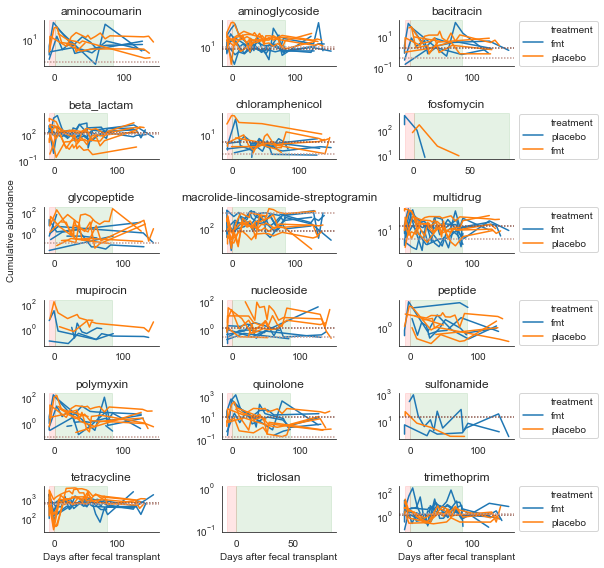

In [21]:
#plot each antibiotic class seperately, using a log axis
fig = plt.figure(figsize = (8.5,8))

counter = 1
for abx_cls, sub_df in amr_cls.groupby('antibiotic_class'):
    ax = fig.add_subplot(6,3,counter)
    sns.lineplot(x='days_past_fmt', y='Count',
                 hue='treatment', units='patient',
                 data=sub_df, estimator=None)
    ax.set_yscale('log')
    ax.set_title(abx_cls)
    
    if counter == 7:
        ax.set_ylabel('Cumulative abundance')
    else:
        ax.set_ylabel('')
    if counter > 15:
        ax.set_xlabel('Days after fecal transplant')
    else:
        ax.set_xlabel('')
    
    
    #label regions of the graph
    ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
    ax.axvspan(0, 84, alpha=0.1, color='green') #capsules
    
    #get mean values from donors
    val_0044 = sub_df.loc[sub_df['patient'] == '0044']['Count'].mean()
    val_0073 = sub_df.loc[sub_df['patient'] == '0073']['Count'].mean()
    #add mean values from donors
    ax.axhline(val_0044, dashes=(1,1), color=dd_pat_col['0044'])
    ax.axhline(val_0073, dashes=(1,1), color=dd_pat_col['0073'])
    
    #make legend
    if counter % 3 == 0:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend_.remove()
    
    counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amr_abundance_byclass_2019-05-05.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amr_abundance_byclass_2019-05-05.pdf',
            dpi=300)

So a few things here.

1. Tetracycline is the major driver of amr since it is so common. It appears to be slightly higher in placebo patients than FMT. It crashes initially because of the depletion of the microbiome
2. Quinolone resistance does appear to increase, but not durably so.
3. Many of the other amr classes also increase upon administration of abx.

In [12]:
#plot quinolone abundance
quin_df = amr_cls.loc[amr_cls['antibiotic_class'] == 'quinolone']
quin_df = quin_df.drop('sample', axis=1)
quin_df = quin_df.merge(md.loc[md['reads_mgx'] > 0], how='outer')

#fill missing data with a pseudo count
quin_df.loc[:, 'Count'] = quin_df['Count'].fillna(quin_df['Count'].min() / 2)

#let's smash everything into 5-day windows
quin_window_mean_dfs = []
for patient, sub_df in quin_df.groupby('patient'):
    #we'll want to join all baseline samples
    #join all abx range samples
    #have the rest in chunks
    if patient in ['0044', '0073']:
        continue
    
    #get baseline and abx
    bl = sub_df.loc[sub_df['days_past_fmt'] < -5]
    bl.loc[:, 'chunk_time'] = -5
    bl_mean = bl.groupby(['patient', 'chunk_time']).mean()['Count']
    bl_mean = bl_mean.reset_index()
    abx = sub_df.loc[sub_df['days_past_fmt'].between(-5, 1)]
    if abx.empty:
        abx_mean = pd.DataFrame({'patient': [],
                                 'chunk_time': [],
                                 'Count': []})
    else:
        abx.loc[:, 'chunk_time'] = 0
        abx_mean = abx.groupby(['patient', 'chunk_time']).mean()['Count']
        abx_mean = abx_mean.reset_index()
    
    pfmt = sub_df.loc[sub_df['days_past_fmt'] > 1]
    pfmt_chunks = []
    for day_range in zip(range(0, int(sub_df['days_past_fmt'].max()), 5),
                         range(5, int(sub_df['days_past_fmt'].max()), 5)):
        chunk = sub_df.loc[sub_df['days_past_fmt'].between(day_range[0], day_range[1])]
        #add time range information
        if chunk.empty:
            chunk = chunk.append({'chunk_time': day_range[1]}, ignore_index=True)
        else:
            chunk.loc[:, 'chunk_time'] = day_range[1]
        pfmt_chunks.append(chunk)
    #now get the mean of values in each chunk
    pfmt_chunks = [chunk.groupby(['patient', 'chunk_time']).mean()['Count'] \
                   for chunk in pfmt_chunks]
    pfmt_chunks = [chunk.reset_index() for chunk in pfmt_chunks]
    pfmt_mean = pd.concat(pfmt_chunks)
    
    quin_window_mean_dfs.append(pd.concat([bl_mean, abx_mean, pfmt_mean]))

quin_window_mean_df = pd.concat(quin_window_mean_dfs)

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


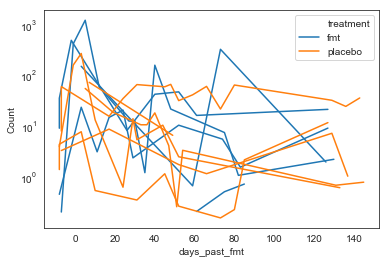

In [27]:
#let quantify the change in quinolone abundance

ax = sns.lineplot(x='days_past_fmt', y='Count',
                 hue='treatment', units='patient',
                 data=tmp_plt, estimator=None)
ax.set_yscale('log')
#ax.set_title(abx_cls)

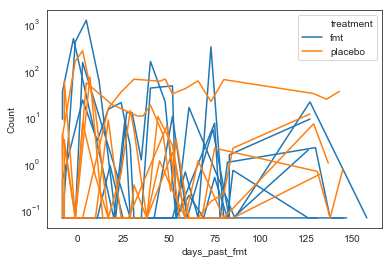

In [28]:
#let quantify the change in quinolone abundance

ax = sns.lineplot(x='days_past_fmt', y='Count',
                 hue='treatment', units='patient',
                 data=quin_df, estimator=None)
ax.set_yscale('log')
#ax.set_title(abx_cls)

In [26]:
#let's only compare baseline quinolone to 10 days after abx
quin_means = []
for patient, sub_df in quin_df.groupby('patient'):
    if patient in ['0044', '0073']:
        continue
    bl_quin = sub_df.loc[sub_df['days_past_fmt'] < -5]['Count'].mean()
    abx_quin = sub_df.loc[sub_df['days_past_fmt'].between(-4, 1)]['Count'].mean()
    pfmt_quin = sub_df.loc[sub_df['days_past_fmt'].between(2, 10)]['Count'].mean()
    
    quin_means.append([patient, bl_quin, 'baseline'])
    quin_means.append([patient, abx_quin, 'abx'])
    quin_means.append([patient, pfmt_quin, 'pfmt'])

quin_means_df = pd.DataFrame(quin_means, columns=['patient', 'quinolone_count',
                                                  'period',])

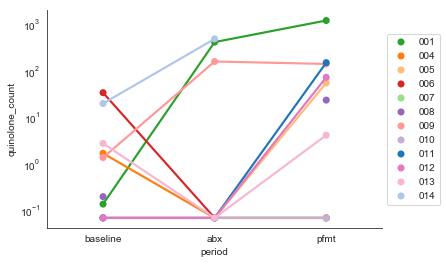

In [58]:
ax = sns.pointplot(x='period', y='quinolone_count',
                   hue='patient', 
                   data=quin_means_df,
                   palette=dd_pat_col,
                   scale=.8)
ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()

In [28]:
# so patient 014 doesn't have any samples from the 10 days immediately after abx
# but they do have a samples from the end of the abx treatment. Use this sample

quin_means_df_alt = quin_means_df.copy()
quin_means_df_alt.loc[34, 'period'] = 'pfmt'
quin_means_df_alt = quin_means_df_alt[:-1]

In [67]:
#color the patients by change

#get a divergent colormap
div_cmap = sns.diverging_palette(240, 10, as_cmap=True)

#get the range of values
chg_vals = tmp_df['pfmt'] - tmp_df['baseline']
chg_vals_norm = (chg_vals-chg_vals.min())/(chg_vals.max()-chg_vals.min())
#make colors
c_dict = {k: div_cmap(v) for k, v in chg_vals_norm.iteritems()}

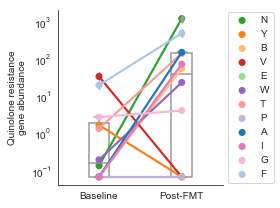

In [70]:
fig = plt.figure(figsize = (4,3))

ax = sns.pointplot(x='period', y='quinolone_count',
                   hue='patient', 
                   data=quin_means_df_alt.loc[quin_means_df_alt['period'] != 'abx'],
                   palette=dd_pat_col,
                   scale=.8)
ax = sns.boxplot(x='period', y='quinolone_count',
                 data=quin_means_df_alt.loc[quin_means_df_alt['period'] != 'abx'],
                 color='white', width=.25)
ax.set_ylabel('Quinolone resistance\ngene abundance')
ax.set_xlabel('')
ax.set_xticklabels(['Baseline', 'Post-FMT'])
ax.set_yscale('log')

#make the legend
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#get the patient IDs
patient_ids = md_pat.set_index('patient').to_dict()['id_pub']
#patient_ids = {f'patient_{k}': v for k, v in patient_ids.items()}
#swap out the labels
for entry in legend.get_texts():
    if entry.get_text() in patient_ids:
        entry.set_text(patient_ids[entry.get_text()])

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/quinolone_chg_2019-04-10.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/quinolone_chg_2019-04-10.pdf',
            dpi=300)

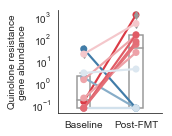

In [71]:
fig = plt.figure(figsize = (2.5,2))

ax = sns.pointplot(x='period', y='quinolone_count',
                   hue='patient', 
                   data=quin_means_df_alt.loc[quin_means_df_alt['period'] != 'abx'],
                   palette=c_dict,
                   scale=.8)
ax = sns.boxplot(x='period', y='quinolone_count',
                 data=quin_means_df_alt.loc[quin_means_df_alt['period'] != 'abx'],
                 color='white', width=.25)
ax.set_ylabel('Quinolone resistance\ngene abundance')
ax.set_xlabel('')
ax.set_xticklabels(['Baseline', 'Post-FMT'])
ax.set_yscale('log')

#make the legend
legend = ax.legend_.remove()

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/quinolone_chg_2019-04-18.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/quinolone_chg_2019-04-18.pdf',
            dpi=300)

In [45]:
#calculate stats
tmp_df = quin_means_df_alt.pivot(index='patient', 
                                 columns='period', 
                                 values='quinolone_count')
tmp_df = tmp_df.applymap(np.log)
stats.ttest_rel(tmp_df['baseline'], tmp_df['pfmt'])

Ttest_relResult(statistic=-2.0964223158952398, pvalue=0.05997057058795695)

## Overall abundance windows

In [21]:
#get sum counts of all amr per sample
plt_df = abun_amr_df.merge(md.loc[md['reads_mgx'] > 0], how='outer') #get any missing mgx samples

#fill missing data with a pseudo count
plt_df.loc[:, 'abun_amr'] = plt_df['abun_amr'].fillna(plt_df['abun_amr'].min() / 2)

#let's smash everything into 5-day windows
amr_window_mean_dfs = []
for patient, sub_df in plt_df.groupby('patient'):
    #we'll want to join all baseline samples
    #join all abx range samples
    #have the rest in chunks
    if patient in ['0044', '0073']:
        continue
    
    #get baseline and abx
    bl = sub_df.loc[sub_df['days_past_fmt'] < -5]
    bl.loc[:, 'chunk_time'] = -5
    bl_mean = bl.groupby(['patient', 'chunk_time']).mean()['abun_amr']
    bl_mean = bl_mean.reset_index()
    abx = sub_df.loc[sub_df['days_past_fmt'].between(-5, 1)]
    if abx.empty:
        abx_mean = pd.DataFrame({'patient': [],
                                 'chunk_time': [],
                                 'abun_amr': []})
    else:
        abx.loc[:, 'chunk_time'] = 0
        abx_mean = abx.groupby(['patient', 'chunk_time']).mean()['abun_amr']
        abx_mean = abx_mean.reset_index()
    
    pfmt = sub_df.loc[sub_df['days_past_fmt'] > 1]
    pfmt_chunks = []
    for day_range in zip(range(0, int(sub_df['days_past_fmt'].max()), 5),
                         range(5, int(sub_df['days_past_fmt'].max()), 5)):
        chunk = sub_df.loc[sub_df['days_past_fmt'].between(day_range[0], day_range[1])]
        #add time range information
        if chunk.empty:
            chunk = chunk.append({'chunk_time': day_range[1]}, ignore_index=True)
        else:
            chunk.loc[:, 'chunk_time'] = day_range[1]
        pfmt_chunks.append(chunk)
    #now get the mean of values in each chunk
    pfmt_chunks = [chunk.groupby(['patient', 'chunk_time']).mean()['abun_amr'] \
                   for chunk in pfmt_chunks]
    pfmt_chunks = [chunk.reset_index() for chunk in pfmt_chunks]
    pfmt_mean = pd.concat(pfmt_chunks)
    
    amr_window_mean_dfs.append(pd.concat([bl_mean, abx_mean, pfmt_mean]))

amr_window_mean_df = pd.concat(amr_window_mean_dfs)

In [23]:
#add metadata
tmp_md = md[['patient', 'patient_donor', 'treatment', 
             'fmt_induction', 'responder_fmt', 
             'patient_plt']].drop_duplicates()
amr_window_mean_df = amr_window_mean_df.merge(tmp_md)

In [25]:
#Do T-test for each data point
ttest_res_amrabun = []
for time, sub_df in amr_window_mean_df.groupby('chunk_time'):
    fmt = sub_df.loc[sub_df['treatment'] == 'fmt']
    placebo = sub_df.loc[sub_df['treatment'] == 'placebo']
    t_res = stats.ttest_ind(fmt['abun_amr'], placebo['abun_amr'])
    ttest_res_amrabun.append([time, *t_res])
ttest_res_amrabun = pd.DataFrame(ttest_res_amrabun, columns=['chunk_time', 't_stat', 'p'])

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


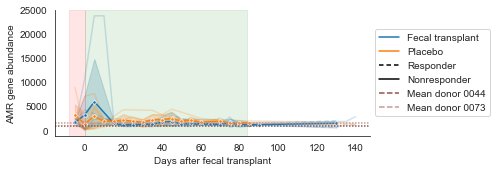

In [29]:
#filter for any time points that have fewer than 3 patients
passing = []
for [treatment, chunk_time], sub_df in amr_window_mean_df.groupby(['treatment',
                                                                     'chunk_time']):
    if sub_df['patient'].nunique() > 2:
        sub_df.loc[:, 'treatment'] = treatment
        sub_df.loc[:, 'chunk_time'] = chunk_time
        passing.append(sub_df)

pass_df = pd.concat(passing)

fig = plt.figure(figsize = (7,2.5))

ax = sns.lineplot(x='chunk_time', y='abun_amr',
                  data=amr_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='abun_amr',
                  data=pass_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('AMR gene abundance')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#get mean values from donors
val_0044 = plt_df.loc[plt_df['patient'] == '0044']['abun_amr'].mean()
val_0073 = plt_df.loc[plt_df['patient'] == '0073']['abun_amr'].mean()
#add mean values from donors
ax.axhline(val_0044, dashes=(1,1), color=dd_pat_col['0044'])
ax.axhline(val_0073, dashes=(1,1), color=dd_pat_col['0073'])

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='Fecal transplant'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='Responder'),
                   Line2D([0], [0], color='black', dashes=(), label='Nonresponder'),
                   Line2D([0], [0], color=dd_pat_col['0044'], linestyle='dashed', 
                          label='Mean donor 0044'),
                   Line2D([0], [0], color=dd_pat_col['0073'], linestyle='dashed', 
                          label='Mean donor 0073')]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

#add asterisks for signficant differences
for time in ttest_res_amrabun.loc[ttest_res_amrabun['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 26000), size=15)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amrabun_windows_2019-04-10.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amrabun_windows_2019-04-10.pdf',
            dpi=300)

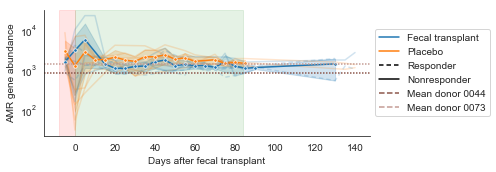

In [30]:
#filter for any time points that have fewer than 3 patients
passing = []
for [treatment, chunk_time], sub_df in amr_window_mean_df.groupby(['treatment',
                                                                     'chunk_time']):
    if sub_df['patient'].nunique() > 2:
        sub_df.loc[:, 'treatment'] = treatment
        sub_df.loc[:, 'chunk_time'] = chunk_time
        passing.append(sub_df)

pass_df = pd.concat(passing)

fig = plt.figure(figsize = (7,2.5))

ax = sns.lineplot(x='chunk_time', y='abun_amr',
                  data=amr_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='abun_amr',
                  data=pass_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('AMR gene abundance')
ax.set_xlabel('Days after fecal transplant')

#set scale
ax.set_yscale('log')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#get mean values from donors
val_0044 = plt_df.loc[plt_df['patient'] == '0044']['abun_amr'].mean()
val_0073 = plt_df.loc[plt_df['patient'] == '0073']['abun_amr'].mean()
#add mean values from donors
ax.axhline(val_0044, dashes=(1,1), color=dd_pat_col['0044'])
ax.axhline(val_0073, dashes=(1,1), color=dd_pat_col['0073'])

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='Fecal transplant'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='Responder'),
                   Line2D([0], [0], color='black', dashes=(), label='Nonresponder'),
                   Line2D([0], [0], color=dd_pat_col['0044'], linestyle='dashed', 
                          label='Mean donor 0044'),
                   Line2D([0], [0], color=dd_pat_col['0073'], linestyle='dashed', 
                          label='Mean donor 0073')]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

#add asterisks for signficant differences
for time in ttest_res_amrabun.loc[ttest_res_amrabun['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 26000), size=15)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amrabun_log_windows_2019-04-10.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amrabun_log_windows_2019-04-10.pdf',
            dpi=300)

## Overall richness plots

In [13]:
#get sum counts of all amr per sample
plt_df = n_amr_obs_df.merge(md.loc[md['reads_mgx'] > 0], how='outer') #get any missing mgx samples

#fill missing data with a pseudo count
plt_df.loc[:, 'n_amr_obs'] = plt_df['n_amr_obs'].fillna(plt_df['n_amr_obs'].min() / 2)

#let's smash everything into 5-day windows
n_amr_window_mean_dfs = []
for patient, sub_df in plt_df.groupby('patient'):
    #we'll want to join all baseline samples
    #join all abx range samples
    #have the rest in chunks
    if patient in ['0044', '0073']:
        continue
    
    #get baseline and abx
    bl = sub_df.loc[sub_df['days_past_fmt'] < -5]
    bl.loc[:, 'chunk_time'] = -5
    bl_mean = bl.groupby(['patient', 'chunk_time']).mean()['n_amr_obs']
    bl_mean = bl_mean.reset_index()
    abx = sub_df.loc[sub_df['days_past_fmt'].between(-5, 1)]
    if abx.empty:
        abx_mean = pd.DataFrame({'patient': [],
                                 'chunk_time': [],
                                 'n_amr_obs': []})
    else:
        abx.loc[:, 'chunk_time'] = 0
        abx_mean = abx.groupby(['patient', 'chunk_time']).mean()['n_amr_obs']
        abx_mean = abx_mean.reset_index()
    
    pfmt = sub_df.loc[sub_df['days_past_fmt'] > 1]
    pfmt_chunks = []
    for day_range in zip(range(0, int(sub_df['days_past_fmt'].max()), 5),
                         range(5, int(sub_df['days_past_fmt'].max()), 5)):
        chunk = sub_df.loc[sub_df['days_past_fmt'].between(day_range[0], day_range[1])]
        #add time range information
        if chunk.empty:
            chunk = chunk.append({'chunk_time': day_range[1]}, ignore_index=True)
        else:
            chunk.loc[:, 'chunk_time'] = day_range[1]
        pfmt_chunks.append(chunk)
    #now get the mean of values in each chunk
    pfmt_chunks = [chunk.groupby(['patient', 'chunk_time']).mean()['n_amr_obs'] \
                   for chunk in pfmt_chunks]
    pfmt_chunks = [chunk.reset_index() for chunk in pfmt_chunks]
    pfmt_mean = pd.concat(pfmt_chunks)
    
    n_amr_window_mean_dfs.append(pd.concat([bl_mean, abx_mean, pfmt_mean]))

n_amr_window_mean_df = pd.concat(n_amr_window_mean_dfs)

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [15]:
#add metadata
tmp_md = md[['patient', 'patient_donor', 'treatment', 
             'fmt_induction', 'responder_fmt', 
             'patient_plt']].drop_duplicates()
n_amr_window_mean_df = n_amr_window_mean_df.merge(tmp_md)

In [16]:
#write this to a file
n_amr_window_mean_df.to_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/function/vf/window_means_cts_2019-05-09.tsv',
                         sep='\t', index=False)

In [17]:
#Do T-test for each data point
ttest_res_namrabun = []
for time, sub_df in n_amr_window_mean_df.groupby('chunk_time'):
    fmt = sub_df.loc[sub_df['treatment'] == 'fmt']
    placebo = sub_df.loc[sub_df['treatment'] == 'placebo']
    t_res = stats.ttest_ind(fmt['n_amr_obs'], placebo['n_amr_obs'])
    ttest_res_namrabun.append([time, *t_res])
ttest_res_namrabun = pd.DataFrame(ttest_res_namrabun, columns=['chunk_time', 't_stat', 'p'])

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


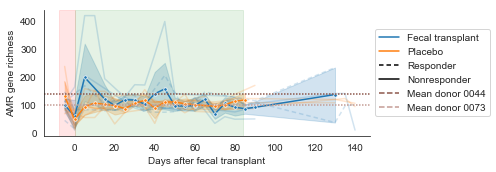

In [45]:
#filter for any time points that have fewer than 3 patients
passing = []
for [treatment, chunk_time], sub_df in n_amr_window_mean_df.groupby(['treatment',
                                                                     'chunk_time']):
    if sub_df['patient'].nunique() > 2:
        sub_df.loc[:, 'treatment'] = treatment
        sub_df.loc[:, 'chunk_time'] = chunk_time
        passing.append(sub_df)

pass_df = pd.concat(passing)

fig = plt.figure(figsize = (7,2.5))

ax = sns.lineplot(x='chunk_time', y='n_amr_obs',
                  data=n_amr_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='n_amr_obs',
                  data=pass_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('AMR gene richness')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#get mean values from donors
val_0044 = plt_df.loc[plt_df['patient'] == '0044']['n_amr_obs'].mean()
val_0073 = plt_df.loc[plt_df['patient'] == '0073']['n_amr_obs'].mean()
#add mean values from donors
ax.axhline(val_0044, dashes=(1,1), color=dd_pat_col['0044'])
ax.axhline(val_0073, dashes=(1,1), color=dd_pat_col['0073'])

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='Fecal transplant'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='Responder'),
                   Line2D([0], [0], color='black', dashes=(), label='Nonresponder'),
                   Line2D([0], [0], color=dd_pat_col['0044'], linestyle='dashed', 
                          label='Mean donor 0044'),
                   Line2D([0], [0], color=dd_pat_col['0073'], linestyle='dashed', 
                          label='Mean donor 0073')]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

#add asterisks for signficant differences
for time in ttest_res_amrabun.loc[ttest_res_amrabun['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 26000), size=15)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amr_richness_windows_2019-05-05.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amr_richness_windows_2019-05-05.pdf',
            dpi=300)

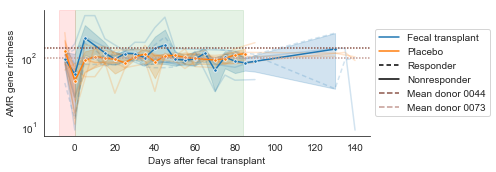

In [46]:
#filter for any time points that have fewer than 3 patients
passing = []
for [treatment, chunk_time], sub_df in n_amr_window_mean_df.groupby(['treatment',
                                                                     'chunk_time']):
    if sub_df['patient'].nunique() > 2:
        sub_df.loc[:, 'treatment'] = treatment
        sub_df.loc[:, 'chunk_time'] = chunk_time
        passing.append(sub_df)

pass_df = pd.concat(passing)

fig = plt.figure(figsize = (7,2.5))

ax = sns.lineplot(x='chunk_time', y='n_amr_obs',
                  data=n_amr_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='n_amr_obs',
                  data=pass_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('AMR gene richness')
ax.set_xlabel('Days after fecal transplant')

#set scale
ax.set_yscale('log')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#get mean values from donors
val_0044 = plt_df.loc[plt_df['patient'] == '0044']['n_amr_obs'].mean()
val_0073 = plt_df.loc[plt_df['patient'] == '0073']['n_amr_obs'].mean()
#add mean values from donors
ax.axhline(val_0044, dashes=(1,1), color=dd_pat_col['0044'])
ax.axhline(val_0073, dashes=(1,1), color=dd_pat_col['0073'])

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='Fecal transplant'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='Responder'),
                   Line2D([0], [0], color='black', dashes=(), label='Nonresponder'),
                   Line2D([0], [0], color=dd_pat_col['0044'], linestyle='dashed', 
                          label='Mean donor 0044'),
                   Line2D([0], [0], color=dd_pat_col['0073'], linestyle='dashed', 
                          label='Mean donor 0073')]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

#add asterisks for signficant differences
for time in ttest_res_amrabun.loc[ttest_res_amrabun['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 26000), size=15)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amr_richness_log_windows_2019-05-05.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amr_richness_log_windows_2019-05-05.pdf',
            dpi=300)

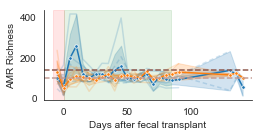

In [24]:
# for each patient, plot the total butyrate cluster counts over time

fig = plt.figure(figsize = (3.75,2))

#get mean abundance for each donor
mean_0044 = plt_df.loc[plt_df['patient'] == '0044']['n_amr_obs'].mean()
mean_0073 = plt_df.loc[plt_df['patient'] == '0073']['n_amr_obs'].mean()

ax = sns.lineplot(x='chunk_time', y='n_amr_obs',
                  data=n_amr_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='n_amr_obs',
                  data=n_amr_window_mean_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('AMR Richness')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(mean_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(mean_0073, color=dd_pat_col['0073'], linestyle='dashed')

ax.legend_.remove()

#add asterisks for signficant differences
for time in ttest_res_namrabun.loc[ttest_res_namrabun['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 410), size=15, ha='center')

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amr_gene_counts_mean_nolgd_2019-05-09.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amr_gene_counts_mean_nolgd_2019-05-09.pdf',
            dpi=300)

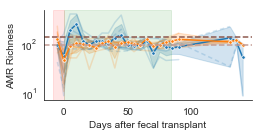

In [23]:
# for each patient, plot the total butyrate cluster counts over time

fig = plt.figure(figsize = (3.75,2))

#get mean abundance for each donor
mean_0044 = plt_df.loc[plt_df['patient'] == '0044']['n_amr_obs'].mean()
mean_0073 = plt_df.loc[plt_df['patient'] == '0073']['n_amr_obs'].mean()

ax = sns.lineplot(x='chunk_time', y='n_amr_obs',
                  data=n_amr_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='n_amr_obs',
                  data=n_amr_window_mean_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('AMR Richness')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#add a line for the mean abundance in the donor samples
ax.axhline(mean_0044, color=dd_pat_col['0044'], linestyle='dashed')
ax.axhline(mean_0073, color=dd_pat_col['0073'], linestyle='dashed')

ax.legend_.remove()

ax.set_yscale('log')

#add asterisks for signficant differences
for time in ttest_res_namrabun.loc[ttest_res_namrabun['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 410), size=15, ha='center')

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amr_gene_counts_mean_nolgd_log_2019-05-09.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amr_gene_counts_mean_nolgd_log_2019-05-09.pdf',
            dpi=300)

### Tetracycline and aminoglycoside windows

In [97]:
#get windows for tetracycline
tetra_df = amr_cls.loc[amr_cls['antibiotic_class'] == 'tetracycline']
tetra_df = tetra_df.drop('sample', axis=1)
tetra_df = tetra_df.merge(md.loc[md['reads_mgx'] > 0], how='outer')

#fill missing data with a pseudo count
tetra_df.loc[:, 'Count'] = tetra_df['Count'].fillna(tetra_df['Count'].min() / 2)

#let's smash everything into 5-day windows
tetra_window_mean_dfs = []
for patient, sub_df in tetra_df.groupby('patient'):
    #we'll want to join all baseline samples
    #join all abx range samples
    #have the rest in chunks
    if patient in ['0044', '0073']:
        continue
    
    #get baseline and abx
    bl = sub_df.loc[sub_df['days_past_fmt'] < -5]
    bl.loc[:, 'chunk_time'] = -5
    bl_mean = bl.groupby(['patient', 'chunk_time']).mean()['Count']
    bl_mean = bl_mean.reset_index()
    abx = sub_df.loc[sub_df['days_past_fmt'].between(-5, 1)]
    if abx.empty:
        abx_mean = pd.DataFrame({'patient': [],
                                 'chunk_time': [],
                                 'Count': []})
    else:
        abx.loc[:, 'chunk_time'] = 0
        abx_mean = abx.groupby(['patient', 'chunk_time']).mean()['Count']
        abx_mean = abx_mean.reset_index()
    
    pfmt = sub_df.loc[sub_df['days_past_fmt'] > 1]
    pfmt_chunks = []
    for day_range in zip(range(0, int(sub_df['days_past_fmt'].max()), 5),
                         range(5, int(sub_df['days_past_fmt'].max()), 5)):
        chunk = sub_df.loc[sub_df['days_past_fmt'].between(day_range[0], day_range[1])]
        #add time range information
        if chunk.empty:
            chunk = chunk.append({'chunk_time': day_range[1]}, ignore_index=True)
        else:
            chunk.loc[:, 'chunk_time'] = day_range[1]
        pfmt_chunks.append(chunk)
    #now get the mean of values in each chunk
    pfmt_chunks = [chunk.groupby(['patient', 'chunk_time']).mean()['Count'] \
                   for chunk in pfmt_chunks]
    pfmt_chunks = [chunk.reset_index() for chunk in pfmt_chunks]
    pfmt_mean = pd.concat(pfmt_chunks)
    
    tetra_window_mean_dfs.append(pd.concat([bl_mean, abx_mean, pfmt_mean]))

tetra_window_mean_df = pd.concat(tetra_window_mean_dfs)

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [102]:
#add metadata
tmp_md = md[['patient', 'patient_donor', 'treatment', 
             'fmt_induction', 'responder_fmt', 
             'patient_plt']].drop_duplicates()
tetra_window_mean_df = tetra_window_mean_df.merge(tmp_md)

In [104]:
#Do T-test for each data point
ttest_res = []
for time, sub_df in tetra_window_mean_df.groupby('chunk_time'):
    fmt = sub_df.loc[sub_df['treatment'] == 'fmt']
    placebo = sub_df.loc[sub_df['treatment'] == 'placebo']
    t_res = stats.ttest_ind(fmt['Count'], placebo['Count'])
    ttest_res.append([time, *t_res])
ttest_res = pd.DataFrame(ttest_res, columns=['chunk_time', 't_stat', 'p'])

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


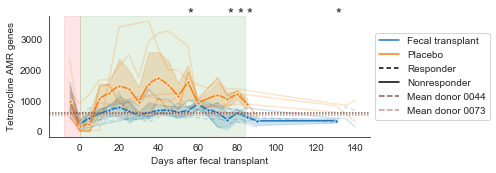

In [117]:
#filter for any time points that have fewer than 3 patients
passing = []
for [treatment, chunk_time], sub_df in tetra_window_mean_df.groupby(['treatment',
                                                                     'chunk_time']):
    if sub_df['patient'].nunique() > 2:
        sub_df.loc[:, 'treatment'] = treatment
        sub_df.loc[:, 'chunk_time'] = chunk_time
        passing.append(sub_df)

pass_df = pd.concat(passing)

fig = plt.figure(figsize = (7,2.5))

ax = sns.lineplot(x='chunk_time', y='Count',
                  data=tetra_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='Count',
                  data=pass_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('Tetracycline AMR genes')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#get mean values from donors
val_0044 = tetra_df.loc[tetra_df['patient'] == '0044']['Count'].mean()
val_0073 = tetra_df.loc[tetra_df['patient'] == '0073']['Count'].mean()
#add mean values from donors
ax.axhline(val_0044, dashes=(1,1), color=dd_pat_col['0044'])
ax.axhline(val_0073, dashes=(1,1), color=dd_pat_col['0073'])

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='Fecal transplant'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='Responder'),
                   Line2D([0], [0], color='black', dashes=(), label='Nonresponder'),
                   Line2D([0], [0], color=dd_pat_col['0044'], linestyle='dashed', 
                          label='Mean donor 0044'),
                   Line2D([0], [0], color=dd_pat_col['0073'], linestyle='dashed', 
                          label='Mean donor 0073')]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

#add asterisks for signficant differences
for time in ttest_res.loc[ttest_res['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 3700), size=15)

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/tetracycline_windows_2019-04-10.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/tetracycline_windows_2019-04-10.pdf',
            dpi=300)

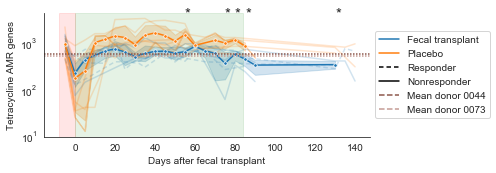

In [118]:
#filter for any time points that have fewer than 3 patients
passing = []
for [treatment, chunk_time], sub_df in tetra_window_mean_df.groupby(['treatment',
                                                                     'chunk_time']):
    if sub_df['patient'].nunique() > 2:
        sub_df.loc[:, 'treatment'] = treatment
        sub_df.loc[:, 'chunk_time'] = chunk_time
        passing.append(sub_df)

pass_df = pd.concat(passing)

fig = plt.figure(figsize = (7,2.5))

ax = sns.lineplot(x='chunk_time', y='Count',
                  data=tetra_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='Count',
                  data=pass_df,
                  hue='treatment', marker='.', markersize=7)
ax.set_yscale('log')

#label axes
ax.set_ylabel('Tetracycline AMR genes')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#get mean values from donors
val_0044 = tetra_df.loc[tetra_df['patient'] == '0044']['Count'].mean()
val_0073 = tetra_df.loc[tetra_df['patient'] == '0073']['Count'].mean()
#add mean values from donors
ax.axhline(val_0044, dashes=(1,1), color=dd_pat_col['0044'])
ax.axhline(val_0073, dashes=(1,1), color=dd_pat_col['0073'])

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='Fecal transplant'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='Responder'),
                   Line2D([0], [0], color='black', dashes=(), label='Nonresponder'),
                   Line2D([0], [0], color=dd_pat_col['0044'], linestyle='dashed', 
                          label='Mean donor 0044'),
                   Line2D([0], [0], color=dd_pat_col['0073'], linestyle='dashed', 
                          label='Mean donor 0073')]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

#add asterisks for signficant differences
for time in ttest_res.loc[ttest_res['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 3700), size=15)

sns.despine()
plt.tight_layout()

#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/tetracycline_windows_2019-04-10.png',
#            dpi=300)
#plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/tetracycline_windows_2019-04-10.pdf',
#            dpi=300)

In [22]:
#get windows for aminoglycoside
amino_df = amr_cls.loc[amr_cls['antibiotic_class'] == 'aminoglycoside']
amino_df = amino_df.drop('sample', axis=1)
amino_df = amino_df.merge(md.loc[md['reads_mgx'] > 0], how='outer')

#fill missing data with a pseudo count
amino_df.loc[:, 'Count'] = amino_df['Count'].fillna(amino_df['Count'].min() / 2)

#let's smash everything into 5-day windows
amino_window_mean_dfs = []
for patient, sub_df in amino_df.groupby('patient'):
    #we'll want to join all baseline samples
    #join all abx range samples
    #have the rest in chunks
    if patient in ['0044', '0073']:
        continue
    
    #get baseline and abx
    bl = sub_df.loc[sub_df['days_past_fmt'] < -5]
    bl.loc[:, 'chunk_time'] = -5
    bl_mean = bl.groupby(['patient', 'chunk_time']).mean()['Count']
    bl_mean = bl_mean.reset_index()
    abx = sub_df.loc[sub_df['days_past_fmt'].between(-5, 1)]
    if abx.empty:
        abx_mean = pd.DataFrame({'patient': [],
                                 'chunk_time': [],
                                 'Count': []})
    else:
        abx.loc[:, 'chunk_time'] = 0
        abx_mean = abx.groupby(['patient', 'chunk_time']).mean()['Count']
        abx_mean = abx_mean.reset_index()
    
    pfmt = sub_df.loc[sub_df['days_past_fmt'] > 1]
    pfmt_chunks = []
    for day_range in zip(range(0, int(sub_df['days_past_fmt'].max()), 5),
                         range(5, int(sub_df['days_past_fmt'].max()), 5)):
        chunk = sub_df.loc[sub_df['days_past_fmt'].between(day_range[0], day_range[1])]
        #add time range information
        if chunk.empty:
            chunk = chunk.append({'chunk_time': day_range[1]}, ignore_index=True)
        else:
            chunk.loc[:, 'chunk_time'] = day_range[1]
        pfmt_chunks.append(chunk)
    #now get the mean of values in each chunk
    pfmt_chunks = [chunk.groupby(['patient', 'chunk_time']).mean()['Count'] \
                   for chunk in pfmt_chunks]
    pfmt_chunks = [chunk.reset_index() for chunk in pfmt_chunks]
    pfmt_mean = pd.concat(pfmt_chunks)
    
    amino_window_mean_dfs.append(pd.concat([bl_mean, abx_mean, pfmt_mean]))

amino_window_mean_df = pd.concat(amino_window_mean_dfs)

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [23]:
#add metadata
tmp_md = md[['patient', 'patient_donor', 'treatment', 
             'fmt_induction', 'responder_fmt', 
             'patient_plt']].drop_duplicates()
amino_window_mean_df = amino_window_mean_df.merge(tmp_md)

In [24]:
#Do T-test for each data point
ttest_res = []
for time, sub_df in amino_window_mean_df.groupby('chunk_time'):
    fmt = sub_df.loc[sub_df['treatment'] == 'fmt']
    placebo = sub_df.loc[sub_df['treatment'] == 'placebo']
    t_res = stats.ttest_ind(fmt['Count'], placebo['Count'])
    ttest_res.append([time, *t_res])
ttest_res = pd.DataFrame(ttest_res, columns=['chunk_time', 't_stat', 'p'])

/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3157: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/Users/ndchu/programs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


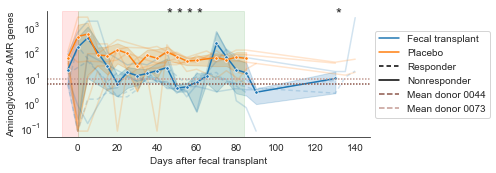

In [25]:
#filter for any time points that have fewer than 3 patients
passing = []
for [treatment, chunk_time], sub_df in amino_window_mean_df.groupby(['treatment',
                                                                     'chunk_time']):
    if sub_df['patient'].nunique() > 2:
        sub_df.loc[:, 'treatment'] = treatment
        sub_df.loc[:, 'chunk_time'] = chunk_time
        passing.append(sub_df)

pass_df = pd.concat(passing)

fig = plt.figure(figsize = (7,2.5))

ax = sns.lineplot(x='chunk_time', y='Count',
                  data=amino_window_mean_df,
                  hue='patient_plt', 
                  palette=dd_pat_treat_name,
                  style='patient_plt',
                  dashes=dd_pat_dash_name,
                  alpha = 0.2)

ax = sns.lineplot(x='chunk_time', y='Count',
                  data=pass_df,
                  hue='treatment', marker='.', markersize=7)

#label axes
ax.set_ylabel('Aminoglycoside AMR genes')
ax.set_xlabel('Days after fecal transplant')

#label regions of the graph
ax.axvspan(-8, 0, alpha=0.1, color='red') #antibiotics
ax.axvspan(0, 84, alpha=0.1, color='green') #capsules

#get mean values from donors
val_0044 = amino_df.loc[amino_df['patient'] == '0044']['Count'].mean()
val_0073 = amino_df.loc[amino_df['patient'] == '0073']['Count'].mean()
#add mean values from donors
ax.axhline(val_0044, dashes=(1,1), color=dd_pat_col['0044'])
ax.axhline(val_0073, dashes=(1,1), color=dd_pat_col['0073'])

#make legends for both plots
legend_elements = [Line2D([0], [0], color=sns.color_palette()[0], label='Fecal transplant'),
                   Line2D([0], [0], color=sns.color_palette()[1], label='Placebo'),
                   Line2D([0], [0], color='black', dashes=(3, 2), label='Responder'),
                   Line2D([0], [0], color='black', dashes=(), label='Nonresponder'),
                   Line2D([0], [0], color=dd_pat_col['0044'], linestyle='dashed', 
                          label='Mean donor 0044'),
                   Line2D([0], [0], color=dd_pat_col['0073'], linestyle='dashed', 
                          label='Mean donor 0073')]
ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1,0.5))

#add asterisks for signficant differences
for time in ttest_res.loc[ttest_res['p'] < 0.05]['chunk_time'].values:
    ax.annotate('*', xy=(time, 2500), size=15)

ax.set_yscale('log')

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/aminoglycoside_windows_2019-05-05.png',
            dpi=300)
plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/aminoglycoside_windows_2019-05-05.pdf',
            dpi=300)

## AMR genes that expand during antibiotics

What AMR genes expand upon administration of antibiotics?

In [180]:
#let's look at gene families whose abundance changes in abx samples
bl_sam = md.loc[md['days_past_fmt'] < -5]['sample_id'].tolist()
bl_sam = [x for x in bl_sam if x in amr_sb_ftab.index]
abx_sam = md.loc[(md['days_past_fmt'] > -5) & \
                 (md['days_past_fmt'] < 1)]['sample_id'].tolist()
abx_sam = [x for x in abx_sam if x in amr_sb_ftab.index]

#make a table of applicable metabolites
#require the gen family to occur in at least 6 samples
tmp = amr_sb_ftab.loc[bl_sam + abx_sam].astype(bool).sum(axis=0) > 6
tmp1 = tmp[tmp].index
mwu_abx = amr_sb_ftab[tmp1].apply(lambda x: stats.mannwhitneyu(x[bl_sam], x[abx_sam]))
mwu_abx = mwu_abx.apply(pd.Series).reset_index().rename(columns={0: 'mwu_stat',
                                                                 1: 'p_value'})
#add the mean value of these genes in each group
mwu_abx.loc[:, 'mean_bl'] = mwu_abx['Family'].apply(lambda x: amr_sb_ftab.loc[bl_sam][x].mean())
mwu_abx.loc[:, 'mean_abx'] = mwu_abx['Family'].apply(lambda x: amr_sb_ftab.loc[abx_sam][x].mean())

#add column for whether the gene went up with abx
mwu_abx.loc[:, 'up_abx'] = mwu_abx.apply(lambda x: True if x['mean_abx'] > x['mean_bl'] else False,
                                         axis=1)


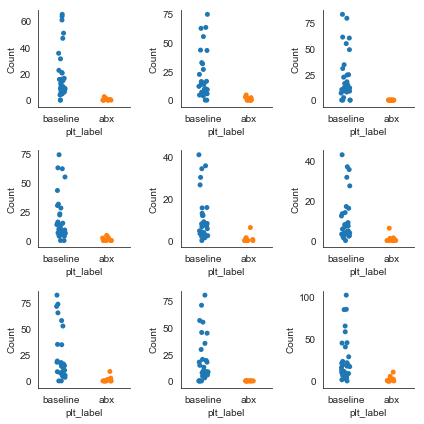

In [182]:
#plot the abundances of the top 9 of these that went down
amr_plt = mwu_abx.loc[~mwu_abx['up_abx']].sort_values('p_value')['Family'].iloc[:9].tolist()

fig = plt.figure(figsize = (6,6))

counter = 1
for gene in amr_plt:
    #make tidy table
    df = pd.melt(amr_sb_ftab[gene].loc[bl_sam + abx_sam].reset_index(),
                 id_vars='sample',
                 var_name='Family',
                 value_name='Count')
    #add baseline versus abx
    df.loc[:, 'plt_label'] = df['sample'].apply(lambda x: 'baseline' if x in bl_sam else 'abx')
    
    ax1 = fig.add_subplot(3,3,counter)
    sns.stripplot(x='plt_label', y='Count',
                  data=df)
    
    counter += 1
sns.despine()
plt.tight_layout()

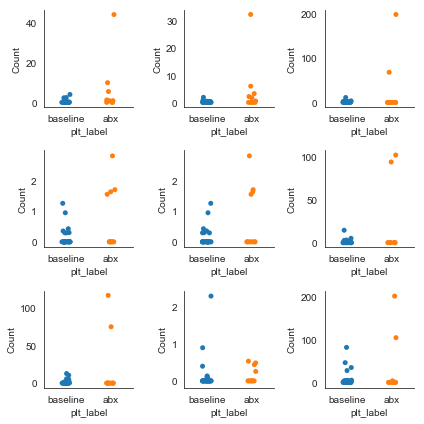

In [183]:
#plot the abundances of the top 9 of these that went up
amr_plt = mwu_abx.loc[mwu_abx['up_abx']].sort_values('p_value')['Family'].iloc[:9].tolist()

fig = plt.figure(figsize = (6,6))

counter = 1
for gene in amr_plt:
    #make tidy table
    df = pd.melt(amr_sb_ftab[gene].loc[bl_sam + abx_sam].reset_index(),
                 id_vars='sample',
                 var_name='Family',
                 value_name='Count')
    #add baseline versus abx
    df.loc[:, 'plt_label'] = df['sample'].apply(lambda x: 'baseline' if x in bl_sam else 'abx')
    
    ax1 = fig.add_subplot(3,3,counter)
    sns.stripplot(x='plt_label', y='Count',
                  data=df)
    
    counter += 1
sns.despine()
plt.tight_layout()

So maybe I shouldn't be surprised, but we mostly see amr genes disappearing upon administration of antibiotics, which makes sense since they are killing everything. The genes that do go up are sometimes involved in multidrug resistance and are attached to many of the bacteria that bloomed in the taxaonomic data (Streptococcus, E coli). This doesn't seem all that informative, but perhaps a small supplemental plot.

## Engraftment of AMR genes

Like bacteria, let's examine AMR genes that both engraft or disappear in different sets of samples:

1. baseline
2. abx
3. fmt treatment
4. Follow-up

In [132]:
#go by each patient, and then each otu
combined_amr = []
combined_mean_abun = []
combined_mean_namr = []
for patient, sub_md in md.loc[md['sample_id'].isin(amr_sb_ftab.index)].groupby('patient'):
    if patient in ['0044', '0073']:
        continue
    
    #get applicable sample sets
    bl_s = sub_md.loc[md['days_past_fmt'] < -5]['sample_id'].tolist()
    abx_s = sub_md.loc[(md['days_past_fmt'] > -5) & \
                       (md['days_past_fmt'] < 1)]['sample_id'].tolist()
    fmt_s = sub_md.loc[(md['days_past_fmt'] > 0) & \
                       (md['days_past_fmt'] < 90)]['sample_id'].tolist()
    fu_s = sub_md.loc[md['days_past_fmt'] > 90]['sample_id'].tolist()
    
    df = amr_sb_ftab.T[sub_md['sample_id'].tolist()]
    df = df.loc[(df != 0).any(axis=1)] #drop rows of zero
    df_b = df.astype(bool)
    
    #get amr sets
    bl_amr_any = list(df_b.loc[df_b[bl_s].any(axis=1)].index)
    bl_amr_all = list(df_b.loc[df_b[bl_s].all(axis=1)].index)
    abx_amr_any = list(df_b.loc[df_b[abx_s].any(axis=1)].index)
    abx_amr_all = list(df_b.loc[df_b[abx_s].all(axis=1)].index)
    fmt_amr_any3 = list(df_b.loc[df_b[fmt_s].sum(axis=1) > 2].index)
    fmt_amr_all = list(df_b.loc[df_b[fmt_s].all(axis=1)].index)
    fu_amr_any = list(df_b.loc[df_b[fu_s].any(axis=1)].index)
    fu_amr_all = list(df_b.loc[df_b[fu_s].all(axis=1)].index)
    
    #add metadata and construct array of amr genes present
    combined_amr.extend([[patient, 'baseline', 'any', x] for x in bl_amr_any])
    combined_amr.extend([[patient, 'baseline', 'all', x] for x in bl_amr_all])
    combined_amr.extend([[patient, 'antibiotics', 'any', x] for x in abx_amr_any])
    combined_amr.extend([[patient, 'antibiotics', 'all', x] for x in abx_amr_all])
    combined_amr.extend([[patient, 'fmt', 'any', x] for x in fmt_amr_any3])
    combined_amr.extend([[patient, 'fmt', 'all', x] for x in fmt_amr_all])
    combined_amr.extend([[patient, 'follow-up', 'any', x] for x in fu_amr_any])
    combined_amr.extend([[patient, 'follow-up', 'all', x] for x in fu_amr_all])
    
    #get the mean number of otus in these samples
    combined_mean_namr.append([patient, 'baseline', 
                                df_b[bl_s].sum().mean(), 
                                df_b[bl_s].sum().median()])
    combined_mean_namr.append([patient, 'antibiotics', 
                                df_b[abx_s].sum().mean(), 
                                df_b[abx_s].sum().median()])
    combined_mean_namr.append([patient, 'fmt', 
                                df_b[fmt_s].sum().mean(), 
                                df_b[fmt_s].sum().median()])
    combined_mean_namr.append([patient, 'follow-up', 
                                df_b[fu_s].sum().mean(), 
                                df_b[fu_s].sum().median()])
    
    #get mean abundances and fraction of samples present of each otu
    if bl_s:
        mean_bl = df[bl_s].mean(axis=1).rename('mean_abundance')
        n_occ_bl = df_b[bl_s].sum(axis=1).rename('n_samples_amr')
        bl_tmp = pd.concat([mean_bl, n_occ_bl], axis=1)
        bl_tmp = bl_tmp.reset_index()
        bl_tmp.loc[:, 'patient'] = patient
        bl_tmp.loc[:, 'time_period'] = 'baseline'
        bl_tmp.loc[:, 'n_samples'] = len(bl_s)
    
    if abx_s:
        mean_abx = df[abx_s].mean(axis=1).rename('mean_abundance')
        n_occ_abx = df_b[abx_s].sum(axis=1).rename('n_samples_amr')
        abx_tmp = pd.concat([mean_abx, n_occ_abx], axis=1)
        abx_tmp = abx_tmp.reset_index()
        abx_tmp.loc[:, 'patient'] = patient
        abx_tmp.loc[:, 'time_period'] = 'antibiotics'
        abx_tmp.loc[:, 'n_samples'] = len(abx_s)
    
    if fmt_s:
        mean_fmt = df[fmt_s].mean(axis=1).rename('mean_abundance')
        n_occ_fmt = df_b[fmt_s].sum(axis=1).rename('n_samples_amr')
        fmt_tmp = pd.concat([mean_fmt, n_occ_fmt], axis=1)
        fmt_tmp = fmt_tmp.reset_index()
        fmt_tmp.loc[:, 'patient'] = patient
        fmt_tmp.loc[:, 'time_period'] = 'fmt'
        fmt_tmp.loc[:, 'n_samples'] = len(fmt_s)
    
    if fu_s:
        mean_fu = df[fu_s].mean(axis=1).rename('mean_abundance')
        n_occ_fu = df_b[fu_s].sum(axis=1).rename('n_samples_amr')
        fu_tmp = pd.concat([mean_fu, n_occ_fu], axis=1)
        fu_tmp = fu_tmp.reset_index()
        fu_tmp.loc[:, 'patient'] = patient
        fu_tmp.loc[:, 'time_period'] = 'follow-up'
        fu_tmp.loc[:, 'n_samples'] = len(fu_s)
    
    combined_mean_abun.extend([bl_tmp, bl_tmp,
                               bl_tmp, bl_tmp])
    
#make dataframes
amr_occ = pd.DataFrame(combined_amr, 
                       columns=['patient', 'time_period', 
                                'criteria', 'amr_sb'])
mean_abun = pd.concat(combined_mean_abun)
n_amr = pd.DataFrame(combined_mean_namr,
                      columns=['patient', 'time_period', 
                               'n_amr_mean', 'n_amr_sb_median'])

In [118]:
#write these tables
amr_occ.to_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/amr/amr_occ_sample_range_OC152018.tsv',
               sep='\t', index=False)
mean_abun.to_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/amr/amr_meanabun_sample_range_OC152018.tsv',
                 sep='\t', index=False)
n_amr.to_csv('/Users/ndchu/Documents/uc_fmt/metagenomics/amr/amr_namr_genes_sample_range_OC152018.tsv',
             sep='\t', index=False)

In [119]:
#also grab the donor amr genes

#list donor samples
sam_0044 = md.loc[md['patient'] == '0044']['sample_id'].tolist()
sam_0073 = md.loc[md['patient'] == '0073']['sample_id'].tolist()

#get sets of amr
any0044 = list(amr_sb_ftab.T.loc[amr_sb_ftab.T[sam_0044].any(axis=1)].index)
all0044 = list(amr_sb_ftab.T.loc[amr_sb_ftab.T[sam_0044].all(axis=1)].index)
any0073 = list(amr_sb_ftab.T.loc[amr_sb_ftab.T[sam_0073].any(axis=1)].index)
all0073 = list(amr_sb_ftab.T.loc[amr_sb_ftab.T[sam_0073].all(axis=1)].index)

#get mean number of amr
mean_namr_0044 = amr_sb_ftab.T[sam_0044].astype(bool).sum().mean()
mean_namr_0073 = amr_sb_ftab.T[sam_0073].astype(bool).sum().mean()

#get mean abundance and fraction of samples present for all donor amr
mean_0044 = amr_sb_ftab.T[sam_0044].mean(axis=1).rename('mean_abundance')
n_occ_0044 = amr_sb_ftab.T.astype(bool)[sam_0044].sum(axis=1).rename('n_samples_amr')
tmp_0044 = pd.concat([mean_bl, n_occ_bl], axis=1)
bl_tmp = bl_tmp.reset_index()
bl_tmp.loc[:, 'patient'] = '0044'
bl_tmp.loc[:, 'n_samples'] = len(sam_0044)

mean_0073 = amr_sb_ftab.T[sam_0073].mean(axis=1).rename('mean_abundance')
n_occ_0073 = amr_sb_ftab.T.astype(bool)[sam_0073].sum(axis=1).rename('n_samples_amr')
tmp_0073 = pd.concat([mean_bl, n_occ_bl], axis=1)
bl_tmp = bl_tmp.reset_index()
bl_tmp.loc[:, 'patient'] = '0073'
bl_tmp.loc[:, 'n_samples'] = len(sam_0073)

## New AMR genes in placebo patients

What genes appear in the the placebo patients during placebo treatment?

## New AMR genes in FMT patients


In [142]:
#let's look for amr genes that were in all fmt samples but not baseline or abx
amr_fmt_new_all = []
for patient, sub_df in amr_occ.groupby('patient'):
    #get only all samples
    bl_amr = sub_df.loc[(sub_df['time_period'] == 'baseline') & \
                        (sub_df['criteria'] == 'all')]
    fmt_amr = sub_df.loc[(sub_df['time_period'] == 'fmt') & \
                         (sub_df['criteria'] == 'all')]
    
    new_amr = set(fmt_amr['amr_sb']) - set(bl_amr['amr_sb'])
    res = pd.DataFrame({'patient': [patient] * len(new_amr), 
                        'amr_sb_new_fmt_all': list(new_amr)})
    
    amr_fmt_new_all.append(res)

#combine table
amr_fmt_new_all = pd.concat(amr_fmt_new_all)
    
amr_fmt_new_anyish = []
for patient, sub_df in amr_occ.groupby('patient'):
    #get only all samples
    bl_amr = sub_df.loc[(sub_df['time_period'] == 'baseline') & \
                        (sub_df['criteria'] == 'all')]
    fmt_amr = sub_df.loc[(sub_df['time_period'] == 'fmt') & \
                         (sub_df['criteria'] == 'any')]
    
    new_amr = set(fmt_amr['amr_sb']) - set(bl_amr['amr_sb'])
    res = pd.DataFrame({'patient': [patient] * len(new_amr), 
                        'amr_sb_new_fmt_anyish': list(new_amr)})
    
    amr_fmt_new_anyish.append(res)

#combine table
amr_fmt_new_anyish = pd.concat(amr_fmt_new_anyish)

amr_fmt_new_allish = []
for patient, sub_df in amr_occ.groupby('patient'):
    #get only all samples
    bl_amr = sub_df.loc[(sub_df['time_period'] == 'baseline') & \
                        (sub_df['criteria'] == 'any')]
    fmt_amr = sub_df.loc[(sub_df['time_period'] == 'fmt') & \
                         (sub_df['criteria'] == 'all')]
    
    new_amr = set(fmt_amr['amr_sb']) - set(bl_amr['amr_sb'])
    res = pd.DataFrame({'patient': [patient] * len(new_amr), 
                        'amr_sb_new_fmt_allish': list(new_amr)})
    
    amr_fmt_new_allish.append(res)

#combine table
amr_fmt_new_allish = pd.concat(amr_fmt_new_allish)

In [144]:
#plot new amr in 007
new_amrs_007 = amr_fmt_new_allish.loc[amr_fmt_new_allish['patient'] == '007']['amr_sb_new_fmt_allish'].to_frame()
new_amrs_007.loc[:, 'amr_id'] = new_amrs_007['amr_sb_new_fmt_allish'].str.split('|').str[2]
new_amrs_007.loc[:, 'amr_id'] = new_amrs_007['amr_id'].str.replace('ARO_', 'ARO:')
new_amrs_007.loc[:, 'amr_id'] = new_amrs_007['amr_id'].str.replace('_1$', '.1')
#add in annotations
new_amrs_007 = new_amrs_007.merge(ncbi_amr, left_on='amr_id', right_on='refseq_prot_accession',
                                  how='left')
new_amrs_007 = new_amrs_007.merge(card_amr, left_on='amr_id', right_on='ARO Accession',
                                  how='left')

### Plotting amr engraftment in Patient 007

In [145]:
tetracyclines = new_amrs_007.loc[(new_amrs_007['antibiotic_class'] == 'tetracycline') | 
                                 (new_amrs_007['Drug Class'].str.contains('tetracycline'))]
mls = new_amrs_007.loc[new_amrs_007['antibiotic_class'] == 'macrolide-lincosamide-streptogramin']
blac = new_amrs_007.loc[(new_amrs_007['antibiotic_class'] == 'beta_lactam') | 
                        (new_amrs_007['Drug Class'].str.contains('beta_lactam'))]

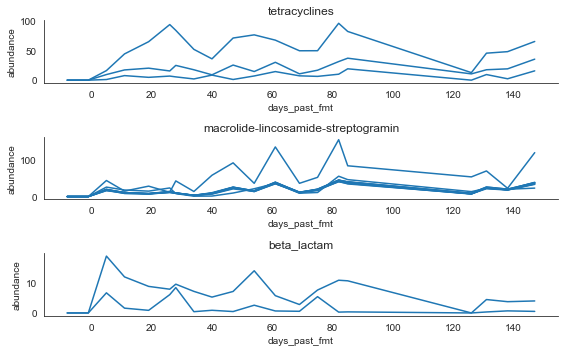

In [149]:
#plot the time series abundances for each of these amy gene families

s_007 = md.loc[md['patient'] == '007']['sample_id'].tolist()
amr_sb_ftab_007 = amr_sb_ftab.T[s_007].T

fig = plt.figure(figsize=(8, 5))

counter = 1
for amr_class in [tetracyclines, mls, blac]:
    amr_df = amr_sb_ftab_007[amr_class['amr_sb_new_fmt_allish'].tolist()]
    amr_df = pd.melt(amr_df.reset_index(), id_vars='sample',
                     var_name='amr_gene_family', value_name='abundance')
    
    amr_df = amr_df.merge(md, left_on='sample', right_on='sample_id')
    
    ax = fig.add_subplot(3,1,counter)
    sns.lineplot(x='days_past_fmt', y='abundance', 
                 data=amr_df,
                 units='amr_gene_family', estimator=None)
    ax.set_title(['tetracyclines', 'macrolide-lincosamide-streptogramin',
                  'beta_lactam'][counter - 1])
    
    counter += 1

sns.despine()
plt.tight_layout()

plt.savefig('/Users/ndchu/Documents/uc_fmt/figures/amr_engraft_007_allish_OC152018.png',
            dpi=300)